Initial 3x3 E. coli concentrations C0 (CFU/100 mL):
[[ 443037.5 1398196.1  643117.2]
 [ 431171.   186622.7  866328. ]
 [ 205476.3 4734989.3 7780155.6]]

Safety threshold C_safe = 2.4e+02 CFU/100 mL
All cells below C_safe at t_end ≈ 30.00 days


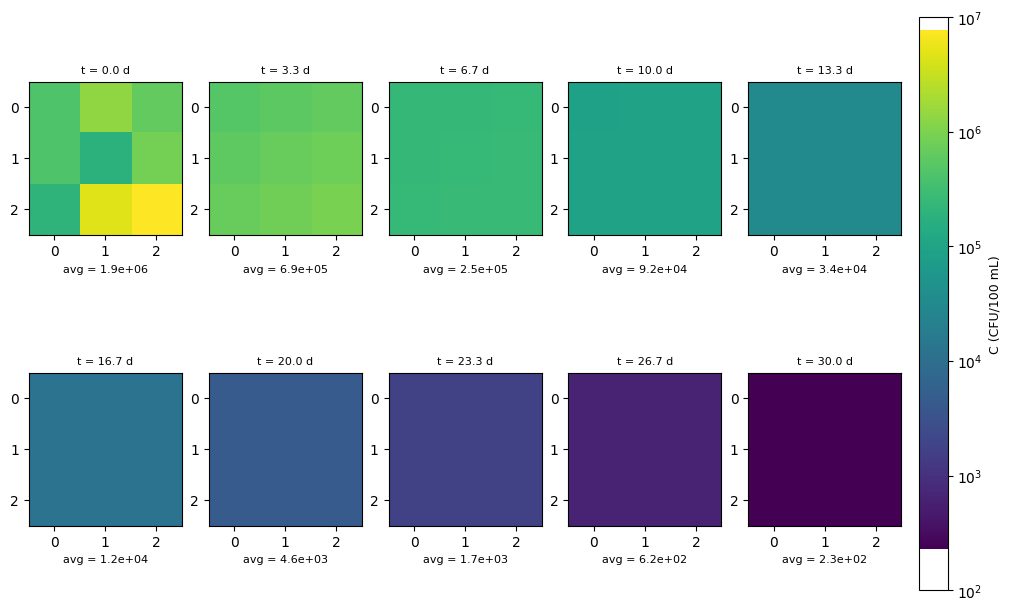

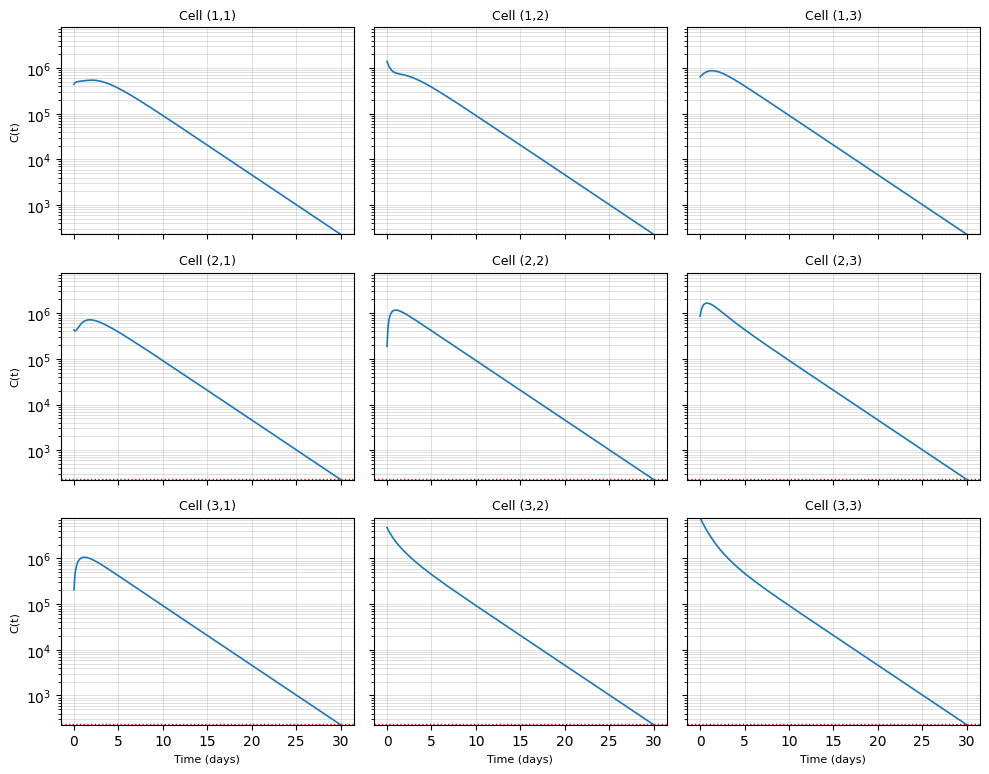

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp

%matplotlib inline

Nx, Ny = 3, 3
N_cells = Nx * Ny

k = 0.3          # die-off rate (1/day)
D = 0.5          # mixing rate between neighboring cells (1/day)

C_safe  = 235    # safety threshold (CFU/100 mL)
max_days = 200.0 # internal max simulation time (days)


def grid_ode(t, C_flat, k, D):
    """
    3x3 grid ODE (closed pond):

      dC_ij/dt = -k*C_ij + D * sum_neighbors (C_neighbor - C_ij)

    Neighbors: up, down, left, right if they exist.
    """
    C = C_flat.reshape((Nx, Ny))
    dCdt = np.zeros_like(C)

    for i in range(Nx):
        for j in range(Ny):
            dC = -k * C[i, j]  # local die-off

            # mixing with neighbors
            if i > 0:         # up
                dC += D * (C[i-1, j] - C[i, j])
            if i < Nx - 1:    # down
                dC += D * (C[i+1, j] - C[i, j])
            if j > 0:         # left
                dC += D * (C[i, j-1] - C[i, j])
            if j < Ny - 1:    # right
                dC += D * (C[i, j+1] - C[i, j])

            dCdt[i, j] = dC

    return dCdt.flatten()

np.random.seed(0)  # change/remove for different random patterns

# log-uniform between 10^4 and 10^7 CFU/100 mL
log_C0  = np.random.uniform(4, 7, size=(Nx, Ny))
C0_grid = 10**log_C0
C0_flat = C0_grid.flatten()

print("Initial 3x3 E. coli concentrations C0 (CFU/100 mL):")
print(np.round(C0_grid, 1))


t_eval = np.linspace(0.0, max_days, 2001)  # dt ~ 0.1 d

sol = solve_ivp(
    fun=lambda t, C: grid_ode(t, C, k=k, D=D),
    t_span=(0.0, max_days),
    y0=C0_flat,
    t_eval=t_eval,
)

C_sol = sol.y  # shape = (9, len(t_eval))

t_end = max_days
idx_end = len(t_eval) - 1  # default

for i_t, t_val in enumerate(t_eval):
    if np.all(C_sol[:, i_t] < C_safe):
        t_end = t_val
        idx_end = i_t
        break

print(f"\nSafety threshold C_safe = {C_safe:.1e} CFU/100 mL")
if idx_end == len(t_eval) - 1 and not np.all(C_sol[:, -1] < C_safe):
    print(f"All cells did NOT drop below C_safe within max_days = {max_days} days.")
else:
    print(f"All cells below C_safe at t_end ≈ {t_end:.2f} days")

# Restrict arrays to [0, t_end]
t_plot      = t_eval[:idx_end + 1]
C_sol_plot  = C_sol[:, :idx_end + 1]


n_snap = 10
snapshot_times = np.linspace(0.0, t_end, n_snap)

# log10 of all C for consistent color scale
logC_all = np.log10(C_sol_plot)
logC_min = np.min(logC_all)
logC_max = np.max(logC_all)
tick_exponents = np.arange(np.floor(logC_min), np.ceil(logC_max) + 1, 1)

fig, axes = plt.subplots(2, 5, figsize=(10, 6), constrained_layout=True)

for n, t_snap in enumerate(snapshot_times):
    idx_t = np.argmin(np.abs(t_plot - t_snap))
    C_flat_snap = C_sol_plot[:, idx_t]
    C_grid_snap = C_flat_snap.reshape((Nx, Ny))
    logC_grid_snap = np.log10(C_grid_snap)

    i_row = n // 5
    j_col = n % 5
    ax = axes[i_row, j_col]

    im = ax.imshow(
        logC_grid_snap,
        origin="upper",         # row 0 at top, row 2 at bottom
        cmap="viridis",
        vmin=logC_min,
        vmax=logC_max,
    )

    ax.set_title(f"t = {t_plot[idx_t]:.1f} d", fontsize=8)
    ax.set_xticks([0, 1, 2])
    ax.set_yticks([0, 1, 2])

    # average concentration for this snapshot
    C_mean_snap = C_grid_snap.mean()
    ax.set_xlabel(f"avg = {C_mean_snap:.1e}", fontsize=8)

# one shared colorbar for all snapshots
cbar = fig.colorbar(
    im,
    ax=axes.ravel().tolist(),
    fraction=0.046,
    pad=0.02,
)
cbar.set_ticks(tick_exponents)
cbar.set_ticklabels([fr"$10^{{{int(e)}}}$" for e in tick_exponents])
cbar.set_label("C (CFU/100 mL)", fontsize=9)

fig.suptitle("",
             y=1.02, fontsize=12)
plt.show()



# ============================================
# 3×3 time-series plots: each cell vs time
# ============================================

# Global y-limits for log scale
C_all_pos = C_sol_plot.flatten()
C_all_pos = C_all_pos[C_all_pos > 0]
y_min = C_all_pos.min()
y_max = C_all_pos.max()

plt.figure(figsize=(10, 8))

for cell_idx in range(N_cells):
    i = cell_idx // Ny   # row index (0,1,2)
    j = cell_idx % Ny    # col index (0,1,2)

    ax = plt.subplot(Nx, Ny, cell_idx + 1)
    C_cell = C_sol_plot[cell_idx, :]

    ax.plot(t_plot, C_cell, linewidth=1.2)
    ax.axhline(C_safe, color="red", linestyle=":", linewidth=1.0)

    ax.set_yscale("log")
    ax.set_ylim(y_min, y_max)

    if i == Nx - 1:
        ax.set_xlabel("Time (days)", fontsize=8)
    else:
        ax.set_xticklabels([])

    if j == 0:
        ax.set_ylabel("C(t)", fontsize=8)
    else:
        ax.set_yticklabels([])

    ax.set_title(f"Cell ({i+1},{j+1})", fontsize=9)
    ax.grid(True, which="both", linewidth=0.4, alpha=0.7)

plt.suptitle("", y=1.02, fontsize=12)
plt.tight_layout()
plt.show()
